In [240]:
import numpy as np
import matplotlib.pyplot as plt

## Theory of Chebyshev Polynomials

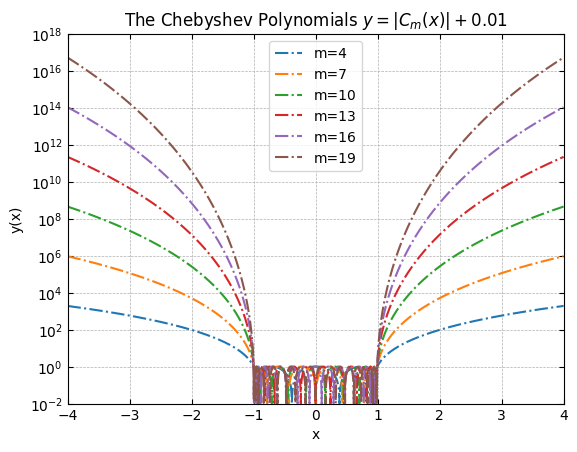

In [241]:
#Create an array from -2 to 2 with 1000 points
x = np.linspace(-4, 4, 100000)

#Write a code for finding m the first kind chebyshev polynomial
m = 20
T = np.zeros((m, x.size))
T[0] = np.ones(x.size)
T[1] = x
C=np.zeros((m, x.size))
for i in range(2, m):
    T[i] = 2*x*T[i-1] - T[i-2] + 0.01

for i in range (m):
    C[i] = np.abs(T[i])+0.01

#Plot the first kind chebyshev polynomial
plt.figure()
for i in range(4,m,3):
    plt.plot(x, C[i], label="m={}".format(i), linestyle="-.")
plt.legend()
plt.xlabel("x")
plt.ylabel("y(x)")
# y range from 10^-2 to 10^18
plt.ylim(1e-2, 1e18)
plt.xlim(-4, 4)
#y in semi log
plt.yscale("log")
# show ticks on both sides
plt.tick_params(axis='both', direction='in')
# Show ticks on right as well as top
plt.tick_params(top=True, right=True)
# Add labels on y axis after 10^2
plt.yticks([1e-2, 1e0, 1e2, 1e4, 1e6, 1e8, 1e10, 1e12, 1e14, 1e16, 1e18], ["$10^{-2}$", "$10^{0}$", "$10^{2}$", "$10^{4}$", "$10^{6}$", "$10^{8}$", "$10^{10}$", "$10^{12}$", "$10^{14}$", "$10^{16}$", "$10^{18}$"])

plt.title("The Chebyshev Polynomials $y = |C_m(x)|+0.01$")
plt.grid( linestyle='--', linewidth=0.5)
plt.show()


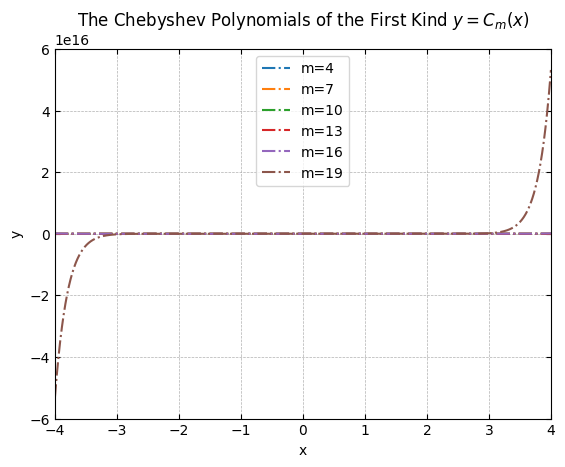

In [242]:
plt.figure()
for i in range(4,m,3):
    plt.plot(x, T[i], label="m={}".format(i), linestyle="-.")
plt.legend( loc='upper center')
plt.xlabel("x")
plt.ylabel("y")
plt.tick_params(axis='both', direction='in')
plt.tick_params(top=True, right=True)
plt.title("The Chebyshev Polynomials of the First Kind $y=C_m(x)$")
plt.xlim(-4,4)
plt.ylim(-6e16,6e16)
plt.grid( linestyle='--', linewidth=0.5)
plt.show()

## The condition number problem!!

In [369]:
n = 1000
N = 10
H = np.random.randn(n,n)
H = 0.5*(H + H.T)
# print("H=",H)
# print("The condition number of H is:",np.linalg.cond(H))


# Create a random matrix of size n x N
A = np.random.randn(n,N)
# print("A=",A)
cond_A = np.linalg.cond(A)
print("The condition number of A is:",cond_A)

# Create a random vector of size n x 1
b = np.random.randn(n)
# print("b=",b)
T = np.zeros((N,n,n))
T[0,:,:] = np.eye(n)
# print("T_0(H)=")
# print(T[0,:,:])
T[1,:,:] = H
# print("T_1(H)=")
# print(T[1,:,:])
for i in range(2, N):
    T[i,:,:] = 2*H @ T[i-1,:,:] - T[i-2,:,:]

# print("T_2(H)b=",(2*H@T[1,:,:] - T[0,:,:])@b)
# print("T_2=",T[2,:,:]@b)

# Create a matrix function such that columns are b , Tb, T^2b, T^3b, ... T^N-1b
B = np.zeros((n, N))
for i in range(N):
    B[:,i] = T[i,:,:] @ b

# print(B[:,2])

# Print the condition number of B
cond_B = np.linalg.cond(B)
print("The condition number of B is:", cond_B)

C = np.zeros((n, N))
for i in range (N):
    C[:,i] = np.linalg.matrix_power(H, i) @ b

# Print the condition number of C
cond_C = np.linalg.cond(C)
print("The condition number of C is:", cond_C)

# eigvals = np.linalg.eigvals(H)
# print("Eigenvalues of H:", eigvals)


The condition number of A is: 1.155668302963191
The condition number of B is: 5.811756695356663e+16
The condition number of C is: 228226280284490.2


## Comparison of Cholesky Factorization, Diagonalization and Hybrid Methods for Solving EVP

In [244]:
# Generate a Real Symmetric Matrix
def generate_hermitian_matrix(n):
    """Generates an n x n random Hermitian matrix."""
    A = np.random.randn(n, n) + 1j * np.random.randn(n, n)  # Random complex matrix
    H = (A + A.conj().T) / 2  # Ensure Hermitian property
    return H

def Chebyshev_poly(H,k):
    M=H.shape[0]
    T_kH=np.zeros((k+1,M,M),dtype=complex)
    T_kH[0,:,:]=np.eye(M)
    T_kH[1,:,:]=H
    for i in range(2,k+1):
        T_kH[i,:,:]=2*H@T_kH[i-1,:,:]-T_kH[i-2,:,:]

    return T_kH[k,:,:]

## Method 1: Cholesky Factorization

In [245]:
def ChFSI_cholalgo(Psi, T_kH):
        
        # Chebyshev Filtering
        Psi_F = T_kH @ Psi

        # Overlap Matrix
        S = Psi_F.conj().T @ Psi_F
        
        #Cholesky decomposition
        L = np.linalg.cholesky(S)
        
        # orthogonalization
        Psi = Psi_F @ (np.linalg.inv(L).conj().T)

        return Psi


def ChFSI_chol(Psi, H, N, k, epsilon, max_iter):
    # H is a Hermitian Matrix
    # N is the number of eigenvalues to be found
    # k is the degree of the Chebyshev polynomial filter

    # M is the dimension of H matrix
    M = H.shape[0]

    #Initializing matrices and variables
    # Psi = np.random.randn(M, N) +1j * np.random.randn(M,N)
    itr=0
    # error = []
    residual = []
    residual.append(1e16)
    # error.append(1e16)
    # error.append(1e16)
    eigenvals = np.zeros((max_iter,N),dtype=complex)
    eigvecs = np.zeros((M,N),dtype=complex)
    T_kH=Chebyshev_poly(H,k)

    # Algorithm
    while itr+1 <= max_iter:

        if residual[itr] <= epsilon:
            break
        
        Psi = ChFSI_cholalgo(Psi, T_kH)
        
        # error
        for i in range(N):
            eigenvals[itr,i] = Psi[:,i].conj().T @ H @ Psi[:,i]
            eigvecs[:,i] = Psi[:,i]
        
        residual.append(np.linalg.norm(H @ Psi - Psi @ np.diag(eigenvals[itr,:]),ord=2))

        # if itr > 0:
        #     error.append(np.max(np.abs(eigenvals[itr,:]-eigenvals[itr-1,:]))) # Calculating infinity norm of the difference of eigenvalues

        itr+=1
        

    return eigenvals[itr-1,:], eigvecs, itr, residual #,error

## Method 2: Eigenvalue Decomposition

In [246]:
def generalized_eigenproblem(H, S):
    """ Solves the generalized eigenvalue problem H X = S X Lambda """
    # Cholesky decomposition of S (S = L L^T)
    L = np.linalg.cholesky(S)
    
    # Transform H to standard eigenvalue problem
    Linv = np.linalg.inv(L)
    H_tilde = Linv @ H @ Linv.conj().T  # Equivalent to L^{-1} H L^{-dag}

    # Solve standard eigenvalue problem
    eigenvals, Q = np.linalg.eigh(H_tilde)

    # Recover original eigenvectors
    eigenvecs = np.linalg.inv(L.conj().T) @ Q

    return eigenvals, eigenvecs

def ChFSI_diagalgo(Psi, H, T_kH):

    # Chebyshev Filtering
        Psi_F = T_kH @ Psi

        # Projected Matrix
        H_proj = Psi_F.conj().T @ H @ Psi_F

        # Overlap Matrix
        S = Psi_F.conj().T @ Psi_F
        
        #Diagonalization
        eigenval, eigenvec = generalized_eigenproblem(H_proj, S)
  
        # orthogonalization
        Psi = Psi_F @ eigenvec

        return eigenval, Psi


def ChFSI_diag(Psi, H, N, k, epsilon, max_iter):
    # H is a Hermitian matrix
    # N is the eigenvalues to be found
    # k is the degree of the Chebyshev polynomial filter

    # M is the dimension of H matrix
    M = H.shape[0]

    # Initialization of the variables
    # Psi = np.random.randn(M, N) +1j * np.random.randn(M,N)
    itr=0
    # error = []
    residual = []
    residual.append(1e16)
    # error.append(1e16)
    # error.append(1e16)
    eigenvals = np.zeros([max_iter,N],dtype=complex)
    eigvecs = np.zeros([M,N],dtype=complex)
    T_kH=Chebyshev_poly(H,k)

    # Algorithm
    while itr+1 <= max_iter:

        if residual[itr] <= epsilon:
            break

        eigenval, Psi = ChFSI_diagalgo(Psi,H,T_kH)

        # error
        for i in range(N):
            eigenvals[itr,i] = eigenval[i]
            eigvecs[:,i] = Psi[:,i]

        residual.append(np.linalg.norm(H @ Psi - Psi @ np.diag(eigenvals[itr,:]),ord=2))

        # if itr > 0:
        #     error.append(np.max(np.abs(eigenvals[itr,:]-eigenvals[itr-1,:]))) # Calculating infinity norm of the difference of eigenvalues

        itr+=1

    return eigenvals[itr-1,:], eigvecs, itr, residual

## Method 3: Hybrid Method

In [259]:
def ChFSI_hybd(Psi, H, N, k, a, epsilon, max_iter):
    # H is a Hermitian matrix
    # N is the eigenvalues to be found
    # k is the degree of the Chebyshev polynomial filter
    # a is the period of algorithm to be used

    # M is the dimension of H matrix
    M = H.shape[0]

    #Initializing matrices and variables
    # Psi = np.random.randn(M, N) +1j * np.random.randn(M,N)
    itr=0
    # error = []
    residual = []
    residual.append(1e16)
    # error.append(1e16)
    # error.append(1e16)
    eigenvals = np.zeros([max_iter,N],dtype=complex)
    eigvecs = np.zeros([M,N],dtype=complex)
    T_kH=Chebyshev_poly(H,k)

    # Algorithm
    while itr+1 <= max_iter:

        if residual[itr] <= epsilon:
            break
        
        if ((itr % a) == 0) and (itr!=0): #or ((itr+1)==max_iter)) and (itr!=0):
            eigenval, Psi = ChFSI_diagalgo(Psi,H,T_kH)
            for i in range(N):
                eigenvals[itr,i] = eigenval[i]
                eigvecs[:,i] = Psi[:,i]

        else:
            Psi = ChFSI_cholalgo(Psi,T_kH)
            for i in range(N):
                eigenvals[itr,i] = Psi[:,i].conj().T @ H @ Psi[:,i]
                eigvecs[:,i] = Psi[:,i]
        
        residual.append(np.linalg.norm(H @ Psi - Psi @ np.diag(eigenvals[itr,:]),ord=2))
        
        # if itr > 0:
        #     error.append(np.max(np.abs(eigenvals[itr,:]-eigenvals[itr-1,:]))) # Calculating infinity norm of the difference of eigenvalues

        itr+=1

    return eigenvals[itr-1,:], eigvecs, itr, residual

In [273]:
# Parameters
M = 100  # Dimension of the matrix
N = 10  # Number of eigenvalues
k = 15  # Degree of the Chebyshev polynomial filter
epsilon = 1e-8  # Tolerance for convergence
max_iter = 1500 # Maximum number of iterations
a = 10 # Period of the algorithm for Hybrid Algorithm
Psi = np.random.randn(M, N) +1j * np.random.randn(M,N)

In [274]:
# Solving the problem
H = generate_hermitian_matrix(M)
eigenvals_diag,eigenvecs_diag, itr_diag, residual_diag = ChFSI_diag(Psi, H, N, k, epsilon, max_iter)
eigenvals_chol,eigenvecs_chol, itr_chol, residual_chol = ChFSI_chol(Psi, H, N, k, epsilon, max_iter)
eigenvals_hybd, eigenvecs_hybd, itr_hybd, residual_hybd = ChFSI_hybd(Psi, H, N, k, a, epsilon, max_iter)
eigenvals, eigenvecs = np.linalg.eigh(H)

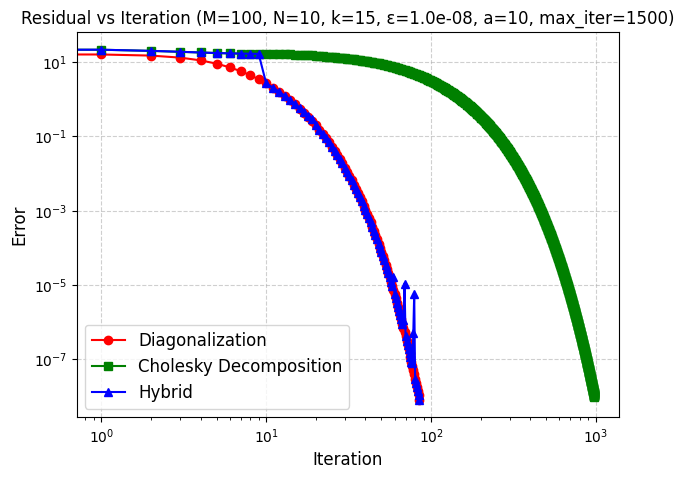

In [275]:
# Plot the error
plt.figure(figsize=(7, 5))
plt.title(f"Residual vs Iteration (M={M}, N={N}, k={k}, ε={epsilon:.1e}, a={a}, max_iter={max_iter})")

plt.plot(np.arange(len(residual_diag)-1), residual_diag[1:], marker='o',  label="Diagonalization", color="red")
plt.plot(np.arange(len(residual_chol)-1), residual_chol[1:], marker='s',  label="Cholesky Decomposition",color="green")
plt.plot(np.arange(len(residual_hybd)-1), residual_hybd[1:], marker='^',  label="Hybrid",color="blue")

plt.yscale("log")
plt.xscale("log")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)
# Legend adjustments
plt.legend(fontsize=12, frameon=True)
plt.show()

In [276]:
print("Eigenvalues (Diagonalization):", eigenvals_diag)
print("Eigenvalues (Cholesky):", eigenvals_chol)
print("Eigenvalues (Hybrid):", eigenvals_hybd)
print("Eigenvalues (Exact):", eigenvals)

Eigenvalues (Diagonalization): [-19.55432385+0.j -18.15843265+0.j -17.68339305+0.j -17.19098882+0.j
 -16.36150474+0.j  16.40152409+0.j  17.21648997+0.j  17.5992632 +0.j
  18.33523969+0.j  19.22593876+0.j]
Eigenvalues (Cholesky): [-19.55432385+7.21644966e-16j  19.22593876-6.66133815e-16j
  18.33523969+6.66133815e-16j -18.15843265-2.22044605e-16j
 -17.68339305+1.11022302e-16j  17.5992632 -4.44089210e-16j
  17.21648997+1.11022302e-16j -17.19098882-1.11022302e-16j
  16.40152409+0.00000000e+00j -16.36150474+5.55111512e-16j]
Eigenvalues (Hybrid): [-19.55432385-5.55111512e-17j -18.15843265+5.55111512e-17j
 -17.68339305-4.44089210e-16j -17.19098882-2.22044605e-16j
 -16.36150474+5.55111512e-17j  16.40152409+0.00000000e+00j
  17.21648997-3.19189120e-16j  17.5992632 -1.11022302e-15j
  18.33523969-7.77156117e-16j  19.22593876+6.66133815e-16j]
Eigenvalues (Exact): [-19.55432385 -18.15843265 -17.68339305 -17.19098882 -16.36150474
 -15.85135752 -15.22347797 -14.69273716 -13.97109607 -13.80262001
 -13

In [16]:
print("Eigenvectors (Diagonalization):")
print(eigenvecs_diag)
print("Eigenvectors (Cholesky):")
print(eigenvecs_chol)
print("Eigenvectors (Hybrid):")
print(eigenvecs_hybd)
print("Eigenvectors (Exact):")
print(eigenvecs)

Eigenvectors (Diagonalization):
[[ 1.04247521e-02+4.31017999e-02j -5.19374591e-02-1.06308184e-01j
   2.21931828e-02-7.34838334e-03j  1.49225753e-02-4.08408607e-02j
  -3.64336042e-02+9.95776775e-02j]
 [-3.38200138e-02-6.83771057e-02j  2.64117481e-02-2.70746795e-02j
   8.68671934e-02+1.93819360e-02j  2.40263508e-02-1.17287233e-01j
   1.08540462e-01+5.30888071e-02j]
 [-1.03884499e-01-9.29429387e-03j  1.00019646e-01-1.42516559e-02j
  -2.04442940e-02+1.26585402e-01j -4.53909795e-02+1.89371488e-04j
  -2.84974487e-02-1.54300223e-02j]
 [-1.33170451e-01-1.91201591e-01j -5.56225099e-02-1.28227562e-01j
   5.66922512e-02-6.07017817e-02j -4.04938755e-02-1.25273133e-01j
  -6.40520785e-02-1.66792625e-01j]
 [ 2.49867872e-04+5.01430904e-02j  6.82799780e-02-1.04167979e-01j
   1.53287328e-01-2.06237060e-05j -9.28716227e-02+3.26532398e-02j
   5.24890990e-02+3.02811039e-02j]
 [ 4.51624315e-02+1.23734503e-02j  7.16159659e-02+5.56605559e-02j
   5.32694388e-02+4.62717033e-02j  1.11629354e-01-1.39686328e-02j
 